In [325]:
import networkx as nx
import pennylane as qml
from pennylane import numpy as np
import collections


In [326]:
def getGraphFromFile():
    graph = nx.read_edgelist('graph.txt', nodetype=int,
    data=(('weight',int),), create_using=nx.Graph())
    return graph

{(0, 1): Text(0.35100556492772234, 0.4717436109017114, '5'),
 (0, 2): Text(0.16282533635290442, 0.5399234128620702, '1'),
 (1, 2): Text(0.013570174482726294, 0.3104880747690111, '7'),
 (1, 3): Text(0.029546265697966256, -0.039923412862070407, '4'),
 (2, 3): Text(-0.15863396287685166, 0.02825638909828837, '2'),
 (3, 4): Text(-0.26370053788167647, -0.6610775492663965, '3')}

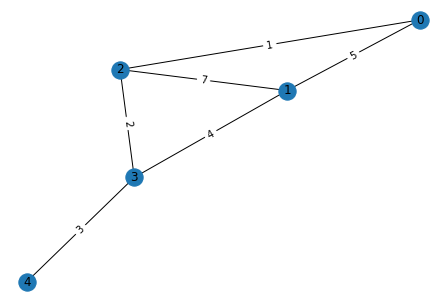

In [327]:
graph = getGraphFromFile()
pos = nx.spring_layout(graph)
nx.draw(graph,pos,with_labels=1)
labels = nx.get_edge_attributes(graph,'weight')
nx.draw_networkx_edge_labels(graph,pos,edge_labels=labels)

In [328]:
qubitsNumber = graph.number_of_nodes()
layersNumber = 1
shotsNumber = 1000
device = qml.device("default.qubit", wires=qubitsNumber, shots=shotsNumber)

In [329]:
def U_b(beta):
    for qubit in range(qubitsNumber):
        qml.RX(2*beta, wires=qubit)

In [330]:
def U_c(gamma):
    for i,j in graph.edges():
        weight = graph.get_edge_data(i,j)['weight']
        qml.CNOT(wires=[i,j])
        qml.RZ(weight*gamma, wires = j)
        qml.CNOT(wires=[i,j])

In [331]:
def compBasisMeasurement(wires):
    n_wires = len(wires)
    return qml.Hermitian(np.diag(range(2 ** n_wires)), wires=wires)

In [332]:
pauli_z = [[1, 0], [0, -1]]
pauli_z_2 = np.kron(pauli_z, pauli_z, requires_grad=False)

@qml.qnode(device)
def circuit(gammas, betas, edge=None):

    for i in range(0,qubitsNumber):
        qml.Hadamard(wires=i)

    for i in range(0,layersNumber):
        U_c(gammas[i])
        U_b(betas[i])

    if edge is None:
        return qml.sample(compBasisMeasurement(range(qubitsNumber)))

    return qml.expval(qml.Hermitian(pauli_z_2, wires=edge))

In [333]:
def costFunction(params):
    gammas = params[0]
    betas = params[1]
    cost = 0
    for i,j in graph.edges():
        weight = graph.get_edge_data(i,j)['weight']
        cost -= 0.5*weight*(1-circuit(gammas, betas, edge=[i,j]))
    return cost

In [334]:
def getMaxCutSolution(params):
    gammas = params[0]
    betas = params[1]
    outputDecimal = circuit(gammas, betas)
    occurrences = collections.Counter(outputDecimal)
    return occurrences

In [335]:
def getOptimizer(optimizerName="GradientDescent", stepSize=0.01):
    if optimizerName == "GradientDescent":
        return qml.GradientDescentOptimizer(stepsize=stepSize)
    if optimizerName == "Adam":
        return qml.AdamOptimizer(stepsize=stepSize)
    if optimizerName == "NesterovMomentum":
        return qml.NesterovMomentumOptimizer(stepsize=stepSize)
    if optimizerName == "Adagrad":
        return qml.AdagradOptimizer(stepsize=stepSize)

In [336]:
if __name__ == '__main__':
    params = 0.01*np.random.rand(2, layersNumber)
    optimizer = getOptimizer(optimizerName="Adam", stepSize=0.3)
    stepNumber = 200
    for i in range(stepNumber):
        params = optimizer.step(costFunction, params)
        print("Results in " + str(i) + " step: " + str(getMaxCutSolution(params)))
    print("Final results: " + str(getMaxCutSolution(params)))

0: 17, 15.0: 17, 16.0: 15, 0.0: 14, 30.0: 14, 13.0: 13, 21.0: 13, 10.0: 12, 7.0: 8, 24.0: 8, 31.0: 7, 1.0: 7, 26.0: 5, 18.0: 5, 5.0: 4, 3.0: 3, 28.0: 1})
Results in 141 step: Counter({22.0: 177, 9.0: 162, 6.0: 65, 25.0: 56, 17.0: 50, 14.0: 43, 29.0: 41, 20.0: 37, 2.0: 34, 11.0: 33, 8.0: 33, 19.0: 30, 23.0: 30, 12.0: 25, 4.0: 19, 27.0: 18, 10.0: 15, 16.0: 14, 15.0: 13, 0.0: 12, 30.0: 12, 24.0: 11, 21.0: 11, 1.0: 11, 31.0: 10, 5.0: 10, 13.0: 9, 7.0: 5, 26.0: 4, 18.0: 4, 28.0: 3, 3.0: 3})
Results in 142 step: Counter({22.0: 163, 9.0: 147, 17.0: 66, 14.0: 61, 6.0: 55, 11.0: 47, 25.0: 46, 2.0: 44, 29.0: 39, 20.0: 34, 19.0: 32, 23.0: 32, 8.0: 30, 12.0: 26, 16.0: 22, 27.0: 21, 15.0: 17, 21.0: 15, 30.0: 13, 4.0: 12, 10.0: 11, 31.0: 10, 26.0: 10, 7.0: 7, 28.0: 7, 5.0: 6, 13.0: 6, 1.0: 6, 3.0: 5, 24.0: 4, 18.0: 3, 0.0: 3})
Results in 143 step: Counter({9.0: 168, 22.0: 158, 17.0: 62, 25.0: 53, 2.0: 51, 6.0: 47, 29.0: 46, 11.0: 45, 14.0: 37, 23.0: 34, 19.0: 33, 8.0: 33, 20.0: 31, 21.0: 22, 16.0: 2

In [337]:
    drawer = qml.draw(circuit)
    print(drawer(params[0],params[1]))

 0: ──H──╭C────────────╭C──╭C─────────────╭C───RX(-1)─────────────────────────────────────────────────────────────────────────────────────────╭┤ Sample[H0] 
 1: ──H──╰X──RZ(2.21)──╰X──│──────────────│───╭C─────────────────╭C──╭C────────────╭C───RX(-1)────────────────────────────────────────────────├┤ Sample[H0] 
 2: ──H────────────────────╰X──RZ(0.442)──╰X──╰X───────RZ(3.09)──╰X──│─────────────│───╭C──────────────────╭C───RX(-1)────────────────────────├┤ Sample[H0] 
 3: ──H──────────────────────────────────────────────────────────────╰X──RZ(1.77)──╰X──╰X───────RZ(0.883)──╰X──╭C─────────────────╭C──RX(-1)──├┤ Sample[H0] 
 4: ──H────────────────────────────────────────────────────────────────────────────────────────────────────────╰X───────RZ(1.33)──╰X──RX(-1)──╰┤ Sample[H0] 
H0 =
[[ 0  0  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]
 [ 0  0  2 ...  0  0  0]
 ...
 [ 0  0  0 ... 29  0  0]
 [ 0  0  0 ...  0 30  0]
 [ 0  0  0 ...  0  0 31]]

